preparation of data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import re
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt


data = pd.read_csv("drive/MyDrive/train.csv", sep=";")

data = data.dropna(subset=['text', 'sentiment'])


data['text'] = data['text'].astype(str)


data['sentiment'] = data['sentiment'].str.lower().str.strip()



nlp = spacy.load("en_core_web_sm")
contractions_dict = {
    "can't": "can not",
    "won't": "will not",
    "n't": " not",
    "'ll": " will",
    "'ve": " have",
    "'re": " are",
    "'d": " would",
    "'m": " am"
}

'''def preprocess_text_spacy(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Process text with spaCy
    doc = nlp(text)

    # Lemmatize and filter out non-alphabetic tokens
    tokens = [token.lemma_ for token in doc if token.is_alpha]

    return " ".join(tokens)



def preprocess_text_spacy(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # Remove mentions
    text = re.sub(r"@\w+", "", text)
    # Expand contractions
    for contraction, expanded in contractions_dict.items():
        text = text.replace(contraction, expanded)
    # Remove special characters and numbers
    text = re.sub(r"[^a-z\s]", "", text)
    # Tokenize and remove stopwords
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(tokens)
'''
def preprocess_text_spacy(text):
    doc = nlp(text)
    expanded_words = []

    for token in doc:

        if token.text.lower() in contractions_dict:
            expanded = contractions_dict[token.text.lower()]
            expanded_words.extend(expanded.split())
        elif token.is_alpha:
            expanded_words.append(token.text)

    return " ".join(expanded_words)

data['cleaned_text'] = data['text'].apply(preprocess_text_spacy)


MAX_LEN = 100
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])
X = pad_sequences(sequences, maxlen=MAX_LEN)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['sentiment'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




Mounted at /content/drive


preparation de model

In [ ]:


model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=MAX_LEN))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=64))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test)
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


340/340 ━━━━━━━━━━━━━━━━━━━━ 138s 390ms/step - accuracy: 0.4369 - loss: 1.0412 - val_accuracy: 0.7015 - val_loss: 0.7333
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 152s 422ms/step - accuracy: 0.7097 - loss: 0.7127 - val_accuracy: 0.7110 - val_loss: 0.6937
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 189s 383ms/step - accuracy: 0.7656 - loss: 0.6101 - val_accuracy: 0.7002 - val_loss: 0.7067
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 145s 392ms/step - accuracy: 0.7970 - loss: 0.5471 - val_accuracy: 0.6954 - val_loss: 0.7573
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 132s 390ms/step - accuracy: 0.8222 - loss: 0.4913 - val_accuracy: 0.6915 - val_loss: 0.7853
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 142s 389ms/step - accuracy: 0.8317 - loss: 0.4706 - val_accuracy: 0.6858 - val_loss: 0.8005
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 142s 391ms/step - accuracy: 0.8402 - loss: 0.4420 - val_accuracy: 0.6917 - val_loss: 0.9238
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 144s 395ms/step - accuracy: 0.8502 - loss: 0.42

visualize results

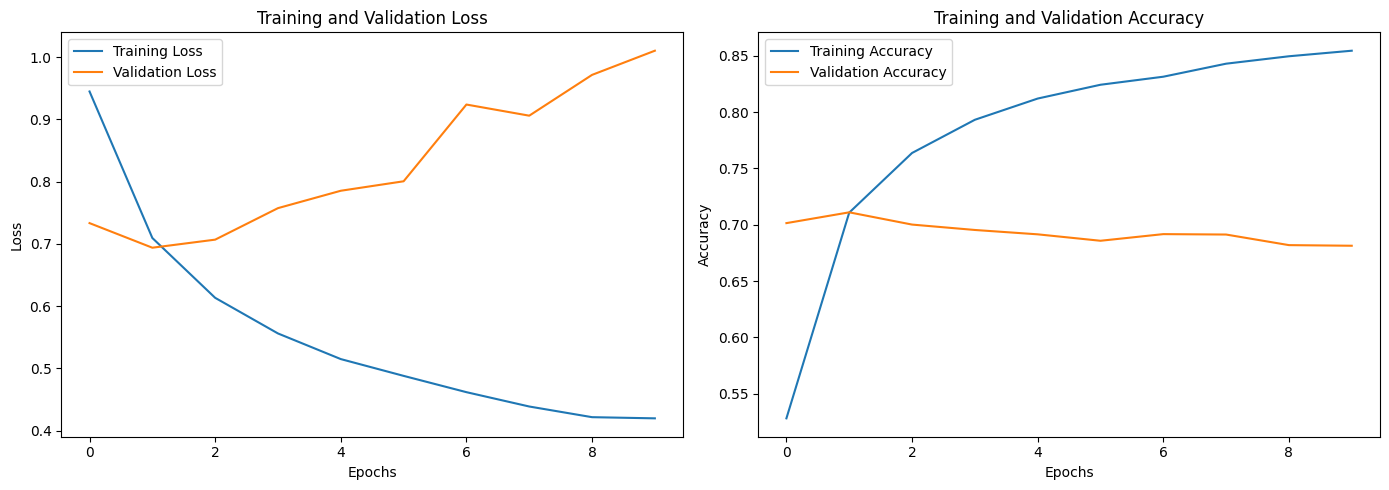

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
Predicted sentiment for the new example: negative
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step
Accuracy on the test set: 0.6814
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step
Confusion Matrix:


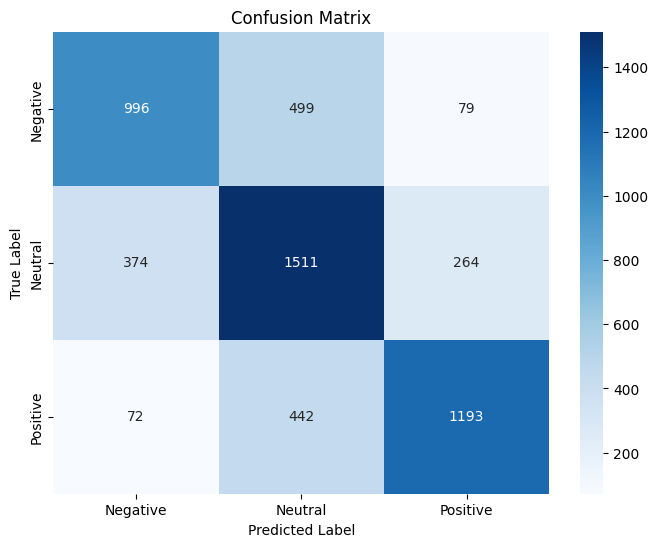


Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.63      0.66      1574
     neutral       0.62      0.70      0.66      2149
    positive       0.78      0.70      0.74      1707

    accuracy                           0.68      5430
   macro avg       0.69      0.68      0.68      5430
weighted avg       0.69      0.68      0.68      5430



In [ ]:

plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

new_example = "I don't hate this product"
new_example_cleaned = preprocess_text_spacy(new_example)
new_example_sequence = tokenizer.texts_to_sequences([new_example_cleaned])
new_example_padded = pad_sequences(new_example_sequence, maxlen=MAX_LEN)


new_example_pred = model.predict(new_example_padded)
predicted_sentiment = label_encoder.inverse_transform([new_example_pred.argmax()])

print(f"Predicted sentiment for the new example: {predicted_sentiment[0]}")


y_pred = model.predict(X_test)
accuracy = (y_pred.argmax(axis=1) == y_test).mean()
print(f"Accuracy on the test set: {accuracy:.4f}")


from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
y_pred = model.predict(X_test).argmax(axis=1)
print("Confusion Matrix:")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


conf_matrix = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])


plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_.astype(str)))


Example

In [ ]:

new_example = "i don't know but this is very bad"
new_example_cleaned = preprocess_text_spacy(new_example)
new_example_sequence = tokenizer.texts_to_sequences([new_example_cleaned])
new_example_padded = pad_sequences(new_example_sequence, maxlen=MAX_LEN)

new_example_pred = model.predict(new_example_padded)
predicted_sentiment = label_encoder.inverse_transform([new_example_pred.argmax()])

print(f"Predicted sentiment for the new example: {predicted_sentiment[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted sentiment for the new example: positive


In [ ]:
model.save("drive/MyDrive/lstm.h5")

In [ ]:
new_example = " What did you get?  My day is alright.. haven't done anything yet."
new_example_cleaned = preprocess_text_spacy(new_example)
new_example_sequence = tokenizer.texts_to_sequences([new_example_cleaned])
new_example_padded = pad_sequences(new_example_sequence, maxlen=MAX_LEN)


new_example_pred = model.predict(new_example_padded)
predicted_sentiment = label_encoder.inverse_transform([new_example_pred.argmax()])

print(f"Text: {new_example} Predicted sentiment : {predicted_sentiment[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Text:  What did you get?  My day is alright.. haven't done anything yet. Predicted sentiment : neutral
